In [1]:
import math
import os
from scipy.odr import * # librería para ajustes
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, zeta   # función error
import scipy.constants as cte   # constantes físicas

In [2]:
class Espectro:
    
    # clase para guardar todos los datos del espectro de manera compacta
    
    def __init__(self):
    
        self.fuente = None
        self.cuentas = []
        self.canales = []
        self.espesor = None

In [3]:
# Lectura de datos

espectros = {}  # me creo un diccionario para separar todos los espectros

carpeta = 'Datos_2021/Formateados/' # Carpeta donde están los datos formateados de todos los 
                                    # espectros

for filename in os.listdir(carpeta):
    elem,d = filename.split("mm.S")[0].split("_")   # me quedo sólo con el nombre y el espesor

    temp_file = open(carpeta+filename, "r")
    temp_list = [int(x) for x in temp_file.readlines()]

    temp_spec = Espectro()
        
    temp_spec.fuente = elem
    temp_spec.espesor = float(d)
    temp_spec.canales = [ch for ch in range(len(temp_list))]
    temp_spec.cuentas = temp_list
    
    if elem in list(espectros):
        espectros[elem].append(temp_spec)
    else:
        espectros[elem] = []
        espectros[elem].append(temp_spec)

# Chequeo que esté todo bien definido
#print(list(espectros))
#
#for elem in espectros.keys():
#    for i in range(len(espectros[elem])):
#        print(espectros[elem][i].fuente,espectros[elem][i].espesor,len(espectros[elem][i]#.canales),len(espectros[elem][i].cuentas))

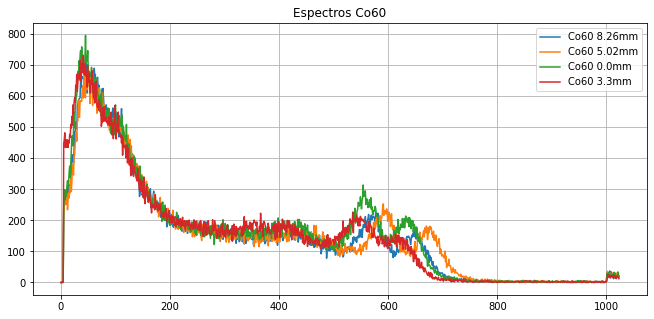

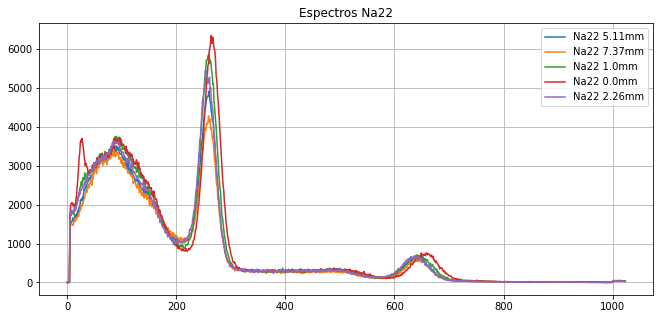

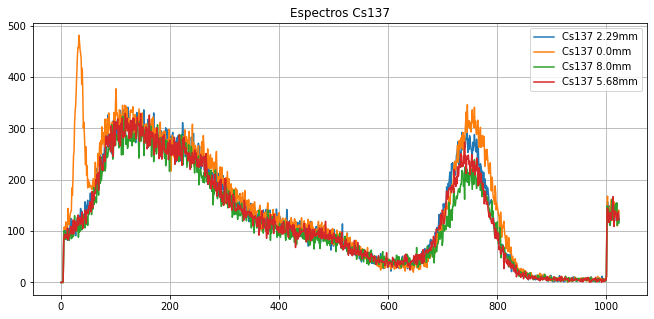

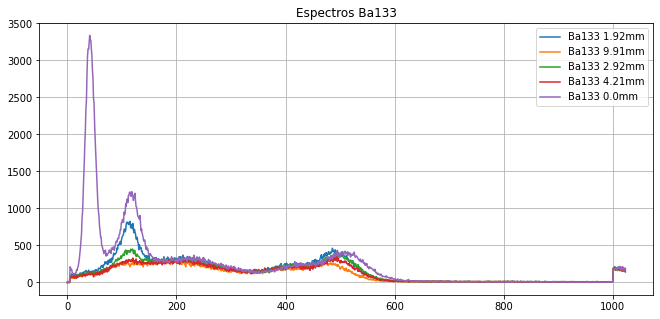

In [4]:
# ploteamos para ver que todo este bien    

for key in espectros.keys():
    
    fig = plt.figure(figsize=(11,5))
    
    for spec in espectros[key]:
        plt.plot(spec.cuentas, label='{} {}mm'.format(key,spec.espesor))
    
    plt.title("Espectros {}".format(key))
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# todas las funciones que voy a usar para los ajustes de ODR
# con y sin fondo, inicialmente uso un modelo de decaimiento exponencial
# mientras sea consistente con el fondo, dado que estoy viendo caidas de intensidad y no
# intensidad absoluta no deberia haber problema 

def fondo(B,x):
    # función error
    return B[0]*(1-erf(B[1]*(x-B[2])))

def gaussian(B,x):
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2))

def dgaussian(B,x):
    # gaussiana doble
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*np.exp(-(x-B[4])**2/(2*B[5]**2))

def gaussian_exp(B,x):
    # gaussiana y función error
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*(1-erf(B[4]*(x-B[5])))

def dgaussian_exp(B,x):
    #gaussiana doble y función error
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*np.exp(-(x-B[4])**2/(2*B[5]**2)) + B[6]*(1-erf(B[7]*(x-B[8])))

# como intensidad uso la integral de -inf a inf porque lo hago sobre la gaussiana desacoplada 
def int_gaussiana(sigma, I_0):
    # intensidad del pico
    return np.sqrt(2*np.pi)*sigma*I_0

def err_int_gaussiana(sigma, I_0, err_sigma, err_I_0):
    # error en la intensidad del pico
    return np.sqrt(2*np.pi)*np.sqrt((I_0*err_sigma)**2 + (sigma*err_I_0)**2)

In [6]:
# esta funcion me deja fittear en las 4 posibles combinaciones que puedo necesitar

def fit_gaussians(x_data, y_data, N_gauss=1, fondo=None, p_init=None):
    
    # armo x e y para ODR y tomo el error como la mitad del ultimo digito
    
    N = len(x_data) # para calcular los grados de libertad del chi cuadrado reducido
    x = x_data
    y = y_data
    sx = 1
    sy = np.sqrt(1/2**2+np.array(y_data))   # el desvío estándar de un proceso de Poisson se 
                                            # estima como sqrt(cuentas)
    
    # elijo el modelo, fijo el numero de parametros y condiciones iniciales dependiendo
    # de la cantidad de gaussianas y si tiene fondo o no
    
    if N_gauss == 1:
        if fondo == 'exp':
            gaussian_model = Model(gaussian_exp)
            N_params = 5
            beta0 = [1,1,1,1,1,1] if p_init == None else p_init
            
        else:
            gaussian_model = Model(gaussian)
            N_params = 3
            beta0 = [1,1,1] if p_init == None else p_init
            
    else:
        if fondo == 'exp':
            gaussian_model = Model(dgaussian_exp)
            N_params = 8
            beta0 = [1,1,1,1,1,1,1,1,1] if p_init == None else p_init
            
        else:
            gaussian_model = Model(dgaussian)
            N_params = 6
            beta0 = [1,1,1,1,1,1] if p_init == None else p_init
        
    
    # paso todos los datos a ODR para hacer el fit
    
    data = RealData(x,y,sx,sy)
    odr_fit = ODR(data, gaussian_model, beta0=beta0)
   
    # calculo el fit y finalmente devuelvo los parametros que me interesan 
    
    odr_fit_output = odr_fit.run()
    
    fit_params = odr_fit_output.beta
    err_fit_params = odr_fit_output.sd_beta
    chi_red_dof = odr_fit_output.res_var/(N-N_params)

    return fit_params, err_fit_params, chi_red_dof

---------------------------------------------------------------------------------
             Ag    mug      sigmag   Ac   B   xc
parámetros:  [ 2.58522568e+02  7.45993695e+02  3.68445966e+01  1.87830332e+04
  1.30824833e-03 -1.05761017e+03]
errores:  [2.47451264e+00 3.27604260e-01 2.96785618e-01 7.93951811e+04
 4.13625781e-04 1.20846503e+03]
chi:  0.002409728214096797


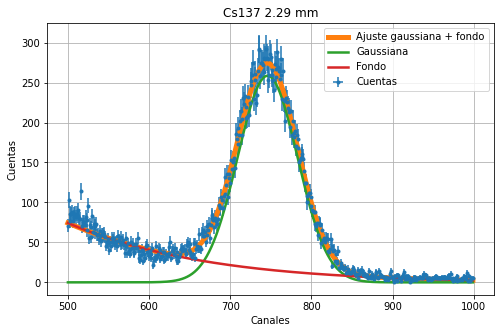

---------------------------------------------------------------------------------
             Ag    mug      sigmag   Ac   B   xc
parámetros:  [ 2.97088177e+02  7.54691751e+02  3.63599932e+01  4.11175659e+04
  1.32035253e-03 -1.16697164e+03]
errores:  [3.03136736e+00 3.41198266e-01 2.97307877e-01 2.11588433e+05
 4.56150912e-04 1.38502620e+03]
chi:  0.003175583654549883


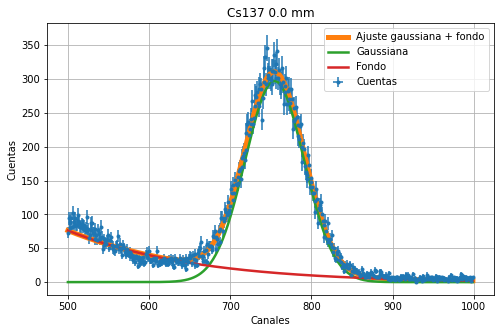

---------------------------------------------------------------------------------
             Ag    mug      sigmag   Ac   B   xc
parámetros:  [ 1.92616659e+02  7.51982698e+02  3.68828891e+01  4.71253535e+03
  1.40163325e-03 -7.14628753e+02]
errores:  [2.19941600e+00 3.95823541e-01 3.69100883e-01 1.30773481e+04
 3.66644970e-04 8.24915574e+02]
chi:  0.002461602572977001


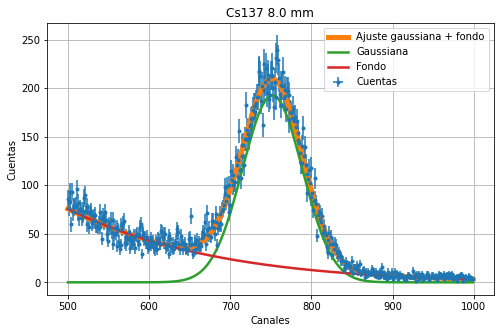

---------------------------------------------------------------------------------
             Ag    mug      sigmag   Ac   B   xc
parámetros:  [ 2.22576299e+02  7.44947661e+02  3.70653837e+01  7.26020405e+03
  1.45051024e-03 -7.45147467e+02]
errores:  [2.23349815e+00 3.48017919e-01 3.20645413e-01 2.04395000e+04
 3.53084228e-04 7.77322298e+02]
chi:  0.002261825758885644


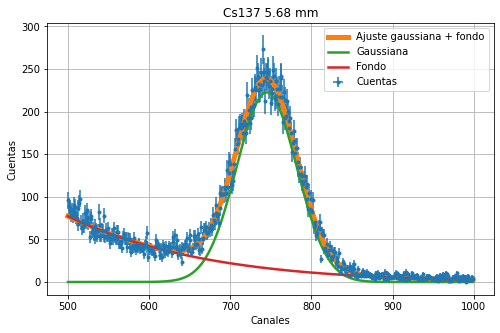

In [7]:
# aca voy a guardar los datos de intensidades para hacer despuees el ajuste 

d_cs137 = []
I_cs137 = []
err_I_cs137 = []

for spec in espectros['Cs137']:
    
    d = spec.espesor
    x = spec.canales[500:1000]  # Selecciono el rango a ajustar
    y = spec.cuentas[500:1000]
    
    p,err_p,chi = fit_gaussians(x, y, N_gauss=1,fondo= 'exp', p_init = [321,751,40,50,0.01,550])
    
    I_0 = p[0]  # amplitud de la gaussiana
    sigma = p[2] 
    
    # guardo tambien los errores para despues propagar 
    
    err_I_0 = err_p[0]
    err_sigma = err_p[2]
    
    d_cs137.append(d/10) # en cm
    I_cs137.append(int_gaussiana(sigma, I_0))
    err_I_cs137.append(err_int_gaussiana(sigma, I_0, err_sigma, err_I_0))
    
    print("---------------------------------------------------------------------------------")
    print("             Ag    mug      sigmag   Ac   B   xc")
    print("parámetros: ",p)
    print("errores: ",err_p)
    print("chi: ", chi)
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(x, y, xerr=0.5, yerr=np.sqrt(1/2**2+np.array(y)), fmt = '.', label='Cuentas')
    plt.plot(x, gaussian_exp(p, x), linewidth=5, label='Ajuste gaussiana + fondo')
    plt.plot(x, gaussian(p[:3], x), linewidth=2.5,label='Gaussiana')
    plt.plot(x, fondo(p[3:], x), linewidth=2.5, label='Fondo')
    plt.title(r"Cs137 {} mm".format(d))
    plt.xlabel("Canales")
    plt.ylabel("Cuentas")
    plt.legend()
    plt.grid()
    plt.show()

d:    [0.229 0.    0.8   0.568]
I:    [23876.03465079 27076.90973271 17807.73614948 20679.37224252]
errI:  [298.69140126 354.04876268 270.38006868 273.9784225 ]
mu: 0.505272765560787 +/- 0.028876703323266147 

mu/rho : 0.0563920497277664 +/- 0.0032228463536576363 

A: 27035.163326146874 +/- 368.52474110249136 

chi_dof**2:  0.8184408738990843 



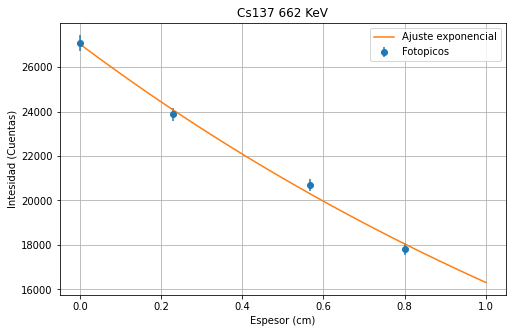

In [18]:
# los paso a arrays para que me lo tome odr
print("d:   ",d_cs137)
print("I:   ",I_cs137)
print("errI: ",err_I_cs137)

d_cs137 = np.array(d_cs137)
I_cs137 = np.array(I_cs137)
err_I_cs137 = np.array(err_I_cs137)

d_cs137_cont = np.linspace(0,1) # este lo voy a usar para plottear el ajuste

rho_cobre = 8.96        # densidad del cobre en g/cm**3, si me interesa medir el coef de 
err_rho_cobre = 0.00001 # atenuación másico. https://physics.nist.gov/cgi-bin/Star/compos.pl?matno=029

def exp(B,x):
    return B[0]*np.exp(-B[1]*x)

exp_model = Model(exp)

data = RealData(d_cs137,I_cs137, sx = 1e-3, sy = err_I_cs137)
odr_fit = ODR(data, exp_model, beta0=[3e4,1e-2])
   
# calculo el fit y finalmente devuelvo los parametros que me interesan 
    
odr_fit_output = odr_fit.run()
fit_params = odr_fit_output.beta
err_fit_params = odr_fit_output.sd_beta
chi_red_dof = odr_fit_output.res_var/(len(I_cs137)-2)

# propago el error para mu que aparece por la densidad

mu = fit_params[1]
err_mu = err_fit_params[1]

mu_rho = mu/rho_cobre
err_mu_rho = mu_rho*np.sqrt((err_mu/mu)**2 + (err_rho_cobre/rho_cobre)**2)

print("mu:", mu, "+/-", err_mu, '\n')
print("mu/rho :", mu_rho, "+/-", err_mu_rho,'\n')
print("A:", fit_params[0], "+/-", err_fit_params[0], '\n')
print("chi_dof**2: ", chi_red_dof,'\n')

# grafico

fig = plt.figure(figsize=(8,5))
plt.errorbar(d_cs137,I_cs137, yerr = err_I_cs137, fmt = 'o', label='Fotopicos')
plt.plot(d_cs137_cont, exp(fit_params,d_cs137_cont), label='Ajuste exponencial')
plt.xlabel("Espesor (cm)")
plt.ylabel("Intesidad (Cuentas)")
plt.title("Cs137 662 KeV")
plt.grid()
plt.legend()
plt.show()

510.99895 1.5e-07


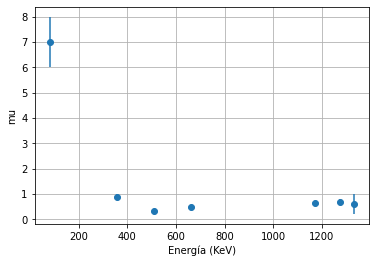

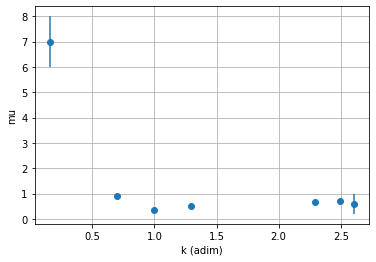

In [9]:
# valores de mu para las distintas fuentes reportados por todos los grupos
mc2 = cte.physical_constants["electron mass energy equivalent in MeV"][0]*1000  # en KeV
errmc2 = cte.physical_constants["electron mass energy equivalent in MeV"][2]*1000   # en KeV
print(mc2,errmc2)

mus=[7,0.9,0.35,0.51,0.66,0.7,0.6] 
errmus=[1,0.1,0.03,0.03,0.05,0.1,0.4]
en=[80.9979,356.0129,mc2,661.657,1173.228,1274.537,1332.492]
erren=[0.0008,0.0007,errmc2,0.003,0.003,0.007,0.004]

k = [e/mc2 for e in en]     # energía adimensionalizada
errk = [erre/mc2 for erre in erren]

plt.errorbar(en,mus,errmus,fmt='o')
plt.xlabel("Energía (KeV)")
plt.ylabel("mu")
plt.grid()
plt.show()

plt.errorbar(k,mus,errmus,fmt='o')
plt.xlabel("k (adim)")
plt.ylabel("mu")
plt.grid()
plt.show()

In [10]:
# Funciones a ajustar

### las difíciles

def SE_fotoelFeo_k(A,k):
    return A/np.array(k)**(7/2)

def SE_fotoel_k_2(A,k):
    return A/np.array(k)**2

def SE_kleinNishina_k(B,k):
    alp = np.array(k)
    return B*((1+alp)/alp**2*(2*(1+alp)/(1+2*alp)-np.log(1+2*alp)/alp)+1/2/alp*np.log(1+2*alp)-(1+3*alp)/(1+2*alp)**2)

def SE_pares_k_feo(C,k):
    kk = np.array(k)
    return np.piecewise(kk, [kk < 2, kk >= 2],[0, C*np.array(((kk[kk >= 2]-2)**3/kk[kk >= 2])*(1 + (kk[kk >= 2]-2)/(kk[kk >= 2]+2)/2 + (23/40)*((kk[kk >= 2]-2)/(kk[kk >= 2]+2))**2 + (37/120)*((kk[kk >= 2]-2)/(kk[kk >= 2]+2))**3))])
    #return np.piecewise(kk, [kk < 2, kk >= 2],[0, C*np.array((28/9)*np.log(2*kk[kk >= 2]) + (218/7) + (2/kk[kk >= 2])**2*(6*np.log(2*kk[kk >= 2]) - 7/2 + (2/3)*np.log(2*kk[kk >= 2])**3 -np.log(kk[kk >= 2])**2 - (np.pi**2/3)*np.log(2*kk[kk >= 2]) + 2*zeta(3) + np.pi**2/6) - (2/kk[kk >= 2])**4*((3/16)*np.log(2*kk[kk >= 2]) + 1/8) - (2/kk[kk >= 2])**6*((29/2304)*np.log(2*kk[kk >= 2]) + 77/13824))])

### las fáciles

def SE_fotoel_k(A,k):
    return A/np.array(k**3)

def SE_compton_k(B,k):
    return B/np.array(k)

def SE_pares_k(C,k):
    kk = np.array(k)
    return np.piecewise(kk, [kk < 2, kk >= 2],[0, C*np.array(np.log(kk[kk >= 2]/2))])

### las sumas

# las fáciles
def SE_suma(C,k):
    return C[0]*SE_fotoel_k(1,k)+C[1]*SE_compton_k(1,k)+C[2]*SE_pares_k(1,k)

def SE_suma_npar(C,k):
    return C[0]*SE_fotoel_k(1,k)+C[1]*SE_compton_k(1,k)

#las difíciles
def SE_suma_dif(C,k):
    return C[0]*SE_fotoelFeo_k(1,k)+C[1]*SE_kleinNishina_k(1,k)+C[2]*SE_pares_k(1,k)

def SE_suma_dif_npar(C,k):
    return C[0]*SE_fotoelFeo_k(1,k)+C[1]*SE_kleinNishina_k(1,k)

#las deformes
def SE_suma_defo(C,k):
    return C[0]*SE_fotoelFeo_k(1,k)+C[1]*SE_kleinNishina_k(1,k)+C[2]*SE_pares_k_feo(1,k)

def SE_suma_defo_2(C,k):
    return C[0]*SE_fotoel_k_2(1,k)+C[1]*SE_kleinNishina_k(1,k)+C[2]*SE_pares_k_feo(1,k)

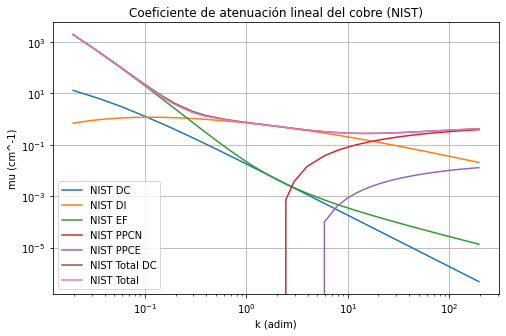

In [11]:
# grafico la curva de mu experimental sacada del NIST. https://physics.nist.gov/cgi-bin/Xcom/xcom3_1

nist_datafile = open('nist_mu_exp_data', "r")
nist_k = []                 # energía adimensionalizada
nist_coh_scat = []          # coherent scattering
nist_incoh_scat = []        # incoherent scattering
nist_foto = []              # efecto fotoeléctrico
nist_par_nuc_field = []     # producción de pares en el campo nuclear
nist_par_elec_field = []    # producción de pares en el campo electrónico
nist_mu_coh = []            # atenuación total con dispersión coherente
nist_mu_incoh = []          # atenuación total sin dispersión coherente

nist_data = [nist_k, nist_coh_scat, nist_incoh_scat, nist_foto, nist_par_nuc_field, nist_par_elec_field, nist_mu_coh, nist_mu_incoh]
nist_names = ['NIST DC','NIST DI','NIST EF','NIST PPCN','NIST PPCE','NIST Total DC','NIST Total']

for line in nist_datafile:
    nums = line.split(" ")
    nist_data[0].append(float(nums[0])*1000/mc2)
    for i in range(len(nums)-1):
        nist_data[i+1].append(float(nums[i+1])*rho_cobre)

fig = plt.figure(figsize=(8,5))
for i in range(len(nist_data)-1):
    plt.plot(nist_data[0], nist_data[i+1], label=nist_names[i])
plt.xlabel("k (adim)")
plt.ylabel("mu (cm^-1)")
plt.title(r"Coeficiente de atenuación lineal del cobre (NIST)")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
# ajuste

def odr_perritou(func,nroparam,betacero):
    exp_model = Model(func)

    data = RealData(k,mus, sx = errk, sy = errmus)
    odr_fit = ODR(data, exp_model, beta0=beta_cero)

    odr_fit_output = odr_fit.run()
    fit_params = odr_fit_output.beta
    err_fit_params = odr_fit_output.sd_beta
    chi_red_dof = odr_fit_output.res_var/(len(mus)-nroparam)

    print("params: ", fit_params, '\n')
    print("err_params: ", err_fit_params, '\n')
    print("chi_dof**2: ", chi_red_dof,'\n')

    return fit_params

# gráfico
def h_plotter(func,params,log):
    kmin = 70/mc2
    kmax = 1400/mc2
    kx=np.linspace(kmin,kmax)

    knist = np.array(nist_k)
    
    # restrinjo los datos del nist
    min_index = 0
    while knist[min_index] < kmin:
            min_index += 1
    min_index -= 1
    max_index = min_index
    while knist[max_index] < kmax:
        max_index += 1
    max_index += 1
    
    knist = knist[min_index:max_index]
    
    mucohnist = np.array(nist_mu_coh)
    mucohnist = mucohnist[min_index:max_index]
    incohscatnist = np.array(nist_incoh_scat[min_index:max_index])

    # grafico
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')
    
    plt.plot(kx, func(params,kx), label='Ajuste')
    plt.plot(kx, SE_fotoel_k(params[0],kx), label='Fotoeléctrico')
    plt.plot(kx, SE_kleinNishina_k(params[1],kx), label='Compton')
    if len(params)==3:
        plt.plot(kx, SE_pares_k(params[2],kx), label='Pares')
    
    plt.plot(np.asarray(knist), np.asarray(mucohnist), label=nist_names[6])
    #plt.plot(np.asarray(knist), np.asarray(incohscatnist), label=nist_names[1])
    
    plt.xlabel("k (adim)")
    plt.ylabel(r"$\mu$ (cm$^{-1}$)")
    plt.title(r"Coeficiente de atenuación lineal del cobre")
    plt.grid()
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.legend()
    plt.show()

---------------------------------------------------------------------
foto -3, Comp -1, pares ln(k/2)
params:  [0.01566578 0.47006653 2.86283331] 

err_params:  [0.01438554 0.08165979 0.99532597] 

chi_dof**2:  3.061031988789622 



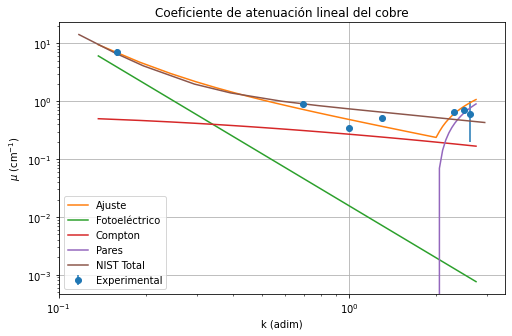

---------------------------------------------------------------------
foto 3, Comp -1, sin pares
params:  [0.0132554  0.51953751] 

err_params:  [0.02249975 0.12506751] 

chi_dof**2:  6.010873161160798 



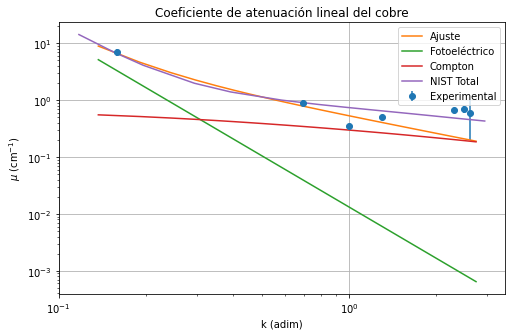

---------------------------------------------------------------------
foto -7/2, Comp K-N, pares ln(k/2)
params:  [0.00984048 0.80448591 2.19130812] 

err_params:  [0.00496042 0.11787507 0.91118286] 

chi_dof**2:  2.4356839363889615 



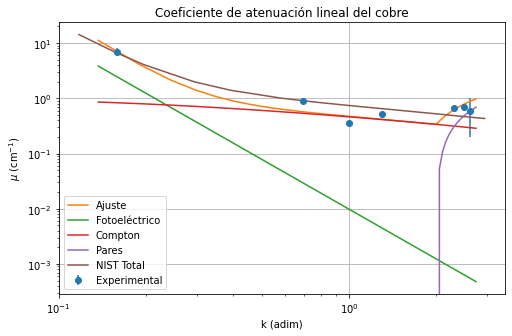

---------------------------------------------------------------------
foto -7/2, Comp K-N, sin pares
params:  [0.00948126 0.89079863] 

err_params:  [0.00693561 0.15705782] 

chi_dof**2:  3.8127490145037166 



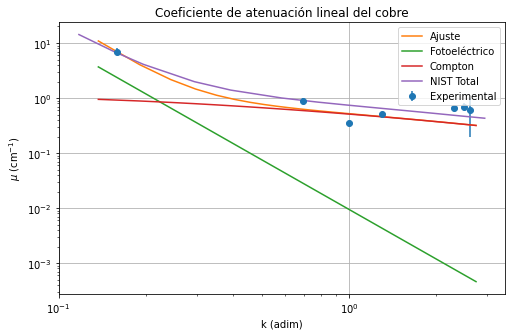

---------------------------------------------------------------------
foto -7/2, Comp K-N, pares defo
params:  [9.69404971e-03 8.39858503e-01 9.92359799e+00] 

err_params:  [6.18506467e-03 1.44014158e-01 6.55718433e+00] 

chi_dof**2:  3.7882862706291625 



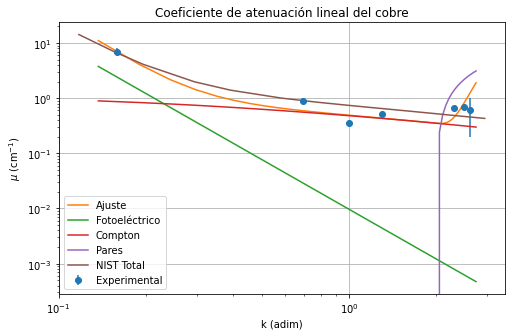

---------------------------------------------------------------------
foto -2, Comp K-N, pares defo
params:  [9.69404971e-03 8.39858503e-01 9.92359799e+00] 

err_params:  [6.18506467e-03 1.44014158e-01 6.55718433e+00] 

chi_dof**2:  3.7882862706291625 



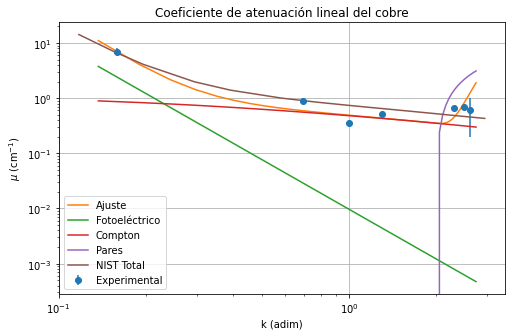

In [13]:
alfa = 1/137    # cte de estructura fina
mc2J = cte.physical_constants["electron mass energy equivalent"][0] # en Joules
r_e = (cte.e**2)/mc2J*100   # radio clásico del electrón en cm

# las fáciles
print("---------------------------------------------------------------------")
print("foto -3, Comp -1, pares ln(k/2)")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma,3,beta_cero)
h_plotter(SE_suma,fit_params,1)

print("---------------------------------------------------------------------")
print("foto 3, Comp -1, sin pares")
beta_cero = [1,100]
fit_params = odr_perritou(SE_suma_npar,2,beta_cero)
h_plotter(SE_suma_npar,fit_params,1)

# las difíciles
print("---------------------------------------------------------------------")
print("foto -7/2, Comp K-N, pares ln(k/2)")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma_dif,3,beta_cero)
h_plotter(SE_suma_dif,fit_params,1)

print("---------------------------------------------------------------------")
print("foto -7/2, Comp K-N, sin pares")
beta_cero = [1,100]
fit_params = odr_perritou(SE_suma_dif_npar,2,beta_cero)
h_plotter(SE_suma_dif_npar,fit_params,1)

# las deformes
print("---------------------------------------------------------------------")
print("foto -7/2, Comp K-N, pares defo")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma_defo,3,beta_cero)
h_plotter(SE_suma_defo,fit_params,1)

# las deformes
print("---------------------------------------------------------------------")
print("foto -2, Comp K-N, pares defo")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma_defo,3,beta_cero)
h_plotter(SE_suma_defo,fit_params,1)

foto -7/2, Comp K-N, pares defo
params:  [9.69404971e-03 8.39858503e-01 9.92359799e+00] 

err_params:  [6.18506467e-03 1.44014158e-01 6.55718433e+00] 

chi_dof**2:  3.7882862706291625 



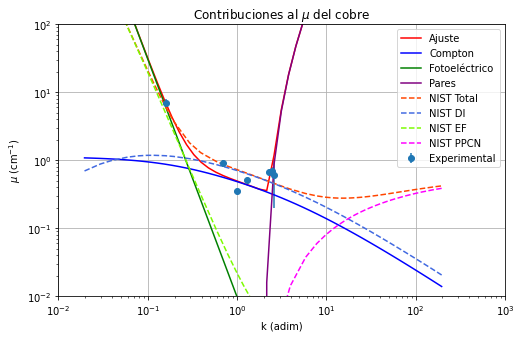

In [14]:
### Comparo contribuciones defo

# el ajuste
print("foto -7/2, Comp K-N, pares defo")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma_defo,3,beta_cero)

# grafico
fig = plt.figure(figsize=(8,5))

# nuestro ajuste
kmin = nist_k[0]
kmax = nist_k[len(nist_k)-1]
kx = np.logspace(np.log10(kmin),np.log10(kmax))

plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')

plt.plot(kx, SE_suma_defo(fit_params,kx), label='Ajuste', color='red')
plt.plot(kx, SE_kleinNishina_k(fit_params[1],kx), label='Compton', color='blue')
plt.plot(kx, SE_fotoelFeo_k(fit_params[0],kx), label='Fotoeléctrico', color='green')
plt.plot(kx, SE_pares_k_feo(fit_params[2],kx), label='Pares', color='purple')

# datos del NIST
plt.plot(nist_data[0], nist_data[7], label=nist_names[6], linestyle='dashed', color='orangered')
plt.plot(nist_data[0], nist_data[2], label=nist_names[1], linestyle='dashed', color='royalblue')
plt.plot(nist_data[0], nist_data[3], label=nist_names[2], linestyle='dashed', color='lawngreen')
plt.plot(nist_data[0], nist_data[4], label=nist_names[3], linestyle='dashed', color='magenta')

plt.xlabel("k (adim)")
plt.ylabel(r"$\mu$ (cm$^{-1}$)")
plt.title(r"Contribuciones al $\mu$ del cobre")
plt.grid()
plt.xlim(10**-2,10**3)
plt.ylim(10**-2,10**2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

foto -7/2, Comp K-N, sin pares
params:  [0.00948126 0.89079863] 

err_params:  [0.00693561 0.15705782] 

chi_dof**2:  3.8127490145037166 



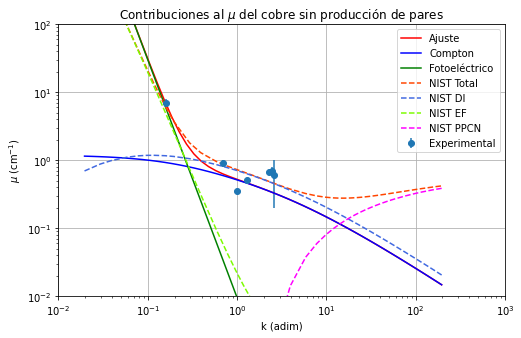

In [15]:
### Comparo contribuciones sin pares

# el ajuste
print("foto -7/2, Comp K-N, sin pares")
beta_cero = [1,100]
fit_params = odr_perritou(SE_suma_dif_npar,2,beta_cero)

# grafico
fig = plt.figure(figsize=(8,5))

# nuestro ajuste
kmin = nist_k[0]
kmax = nist_k[len(nist_k)-1]
kx = np.logspace(np.log10(kmin),np.log10(kmax))

plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')

plt.plot(kx, SE_suma_dif_npar(fit_params,kx), label='Ajuste', color='red')
plt.plot(kx, SE_kleinNishina_k(fit_params[1],kx), label='Compton', color='blue')
plt.plot(kx, SE_fotoelFeo_k(fit_params[0],kx), label='Fotoeléctrico', color='green')

# datos del NIST
plt.plot(nist_data[0], nist_data[7], label=nist_names[6], linestyle='dashed', color='orangered')
plt.plot(nist_data[0], nist_data[2], label=nist_names[1], linestyle='dashed', color='royalblue')
plt.plot(nist_data[0], nist_data[3], label=nist_names[2], linestyle='dashed', color='lawngreen')
plt.plot(nist_data[0], nist_data[4], label=nist_names[3], linestyle='dashed', color='magenta')

plt.xlabel("k (adim)")
plt.ylabel(r"$\mu$ (cm$^{-1}$)")
plt.title(r"Contribuciones al $\mu$ del cobre sin producción de pares")
plt.grid()
plt.xlim(10**-2,10**3)
plt.ylim(10**-2,10**2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

foto -3, Comp -1, pares ln(k/2)
params:  [0.01566578 0.47006653 2.86283331] 

err_params:  [0.01438554 0.08165979 0.99532597] 

chi_dof**2:  3.061031988789622 



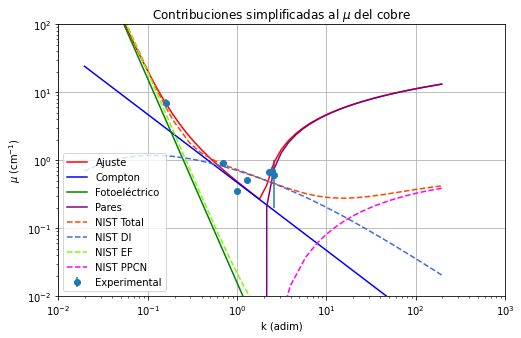

In [16]:
### Comparo contribuciones fáciles

# el ajuste
print("foto -3, Comp -1, pares ln(k/2)")
beta_cero = [1,100,0.001]
fit_params = odr_perritou(SE_suma,3,beta_cero)

# grafico
fig = plt.figure(figsize=(8,5))

# nuestro ajuste
kmin = nist_k[0]
kmax = nist_k[len(nist_k)-1]
kx = np.logspace(np.log10(kmin),np.log10(kmax))

plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')

plt.plot(kx, SE_suma(fit_params,kx), label='Ajuste', color='red')
plt.plot(kx, SE_compton_k(fit_params[1],kx), label='Compton', color='blue')
plt.plot(kx, SE_fotoel_k(fit_params[0],kx), label='Fotoeléctrico', color='green')
plt.plot(kx, SE_pares_k(fit_params[2],kx), label='Pares', color='purple')

# datos del NIST
plt.plot(nist_data[0], nist_data[7], label=nist_names[6], linestyle='dashed', color='orangered')
plt.plot(nist_data[0], nist_data[2], label=nist_names[1], linestyle='dashed', color='royalblue')
plt.plot(nist_data[0], nist_data[3], label=nist_names[2], linestyle='dashed', color='lawngreen')
plt.plot(nist_data[0], nist_data[4], label=nist_names[3], linestyle='dashed', color='magenta')

plt.xlabel("k (adim)")
plt.ylabel(r"$\mu$ (cm$^{-1}$)")
plt.title(r"Contribuciones simplificadas al $\mu$ del cobre")
plt.grid()
plt.xlim(10**-2,10**3)
plt.ylim(10**-2,10**2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

foto -3, Comp -1, sin pares
params:  [0.0132554  0.51953751] 

err_params:  [0.02249975 0.12506751] 

chi_dof**2:  6.010873161160798 



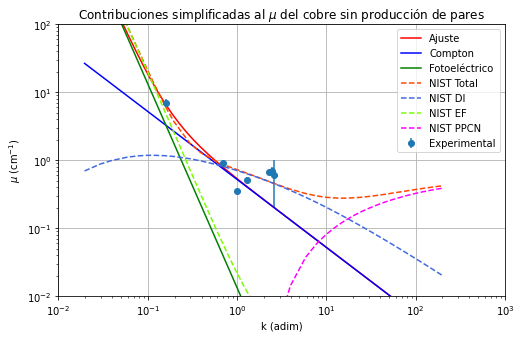

In [17]:
### Comparo contribuciones fáciles sin pares

# el ajuste
print("foto -3, Comp -1, sin pares")
beta_cero = [1,100]
fit_params = odr_perritou(SE_suma_npar,2,beta_cero)

# grafico
fig = plt.figure(figsize=(8,5))

# nuestro ajuste
kmin = nist_k[0]
kmax = nist_k[len(nist_k)-1]
kx = np.logspace(np.log10(kmin),np.log10(kmax))

plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')

plt.plot(kx, SE_suma_npar(fit_params,kx), label='Ajuste', color='red')
plt.plot(kx, SE_compton_k(fit_params[1],kx), label='Compton', color='blue')
plt.plot(kx, SE_fotoel_k(fit_params[0],kx), label='Fotoeléctrico', color='green')

# datos del NIST
plt.plot(nist_data[0], nist_data[7], label=nist_names[6], linestyle='dashed', color='orangered')
plt.plot(nist_data[0], nist_data[2], label=nist_names[1], linestyle='dashed', color='royalblue')
plt.plot(nist_data[0], nist_data[3], label=nist_names[2], linestyle='dashed', color='lawngreen')
plt.plot(nist_data[0], nist_data[4], label=nist_names[3], linestyle='dashed', color='magenta')

plt.xlabel("k (adim)")
plt.ylabel(r"$\mu$ (cm$^{-1}$)")
plt.title(r"Contribuciones simplificadas al $\mu$ del cobre sin producción de pares")
plt.grid()
plt.xlim(10**-2,10**3)
plt.ylim(10**-2,10**2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()